In [1]:
import pandas as pd
import pickle
import seaborn as sns
import string
import numpy as np
sns.set_theme(style="darkgrid")
import matplotlib.pyplot as plt

In [2]:
import nltk, math, codecs
from gensim.models import Doc2Vec
from sklearn.cluster import KMeans
import re
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import redditcleaner

In [27]:
# load data
df = pd.read_parquet('./all_migraine_processed.parquet')
df = df.reset_index().drop('index',1)

In this example, we perform topic modelling on a segment of the Reddit dataset. As a result, in the following code block, we save the indicies of the segmented data. We will later use these indicies when calling the vector embeddings of the segemented data.

In [4]:
original_indicies = df[(df['subreddit']=='relationships') | (df['subreddit']=='relationship_advice')].index
lines = df[(df['subreddit']=='relationships') | (df['subreddit']=='relationship_advice')].noKeyword.values

In [6]:
# Calculate the cosine similarity of each document vector with a topic's centroid
def getCloseness(labels, vectors, centroids):
    document_closeness = list(range(len(labels)))
    for cluster, centroid in enumerate(centroids):
        indicies = [i for i in range(len(labels)) if labels[i] == cluster] #indicies of items in the cluster
        for index in indicies:
            document_closeness[index] = 1 - distance.cosine(centroid, vectors[index])
    return document_closeness

In [7]:
# Identify the most n frequent bigrams and trigrams
def frequentNgrams(tokens,n=20):
        vec = CountVectorizer(lowercase=False,ngram_range=(2,3)).fit(tokens)
        bag_of_words = vec.transform(tokens)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:n]

In [9]:
# Identify the top n bigrams and trigrams having the highest TF-IDF score (the most important ones)
def tfidfNgrams(tokens,n=20):
        vec = TfidfVectorizer(lowercase=False,ngram_range=(2,3),norm='l2').fit(tokens)
        bag_of_words = vec.transform(tokens)
        sum_words = bag_of_words.sum(axis=0) 
        words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
        words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
        return words_freq[:n]

## Identify the best topic number

Perform quick topic modellings to identify the best number of topics

In [10]:
import torch
import numpy as np
from kmeans_pytorch import kmeans, kmeans_predict
import time
from fast_pytorch_kmeans import KMeans

def perform_quick_topic_modelling(epoch,size=100,_range=range(5,110,5),lines=lines):
    model_path = f'./Models/pain_nostop_vec_{size}_epoch_{epoch}.model'
    scores = {}
    vectors = []
    model = Doc2Vec.load(model_path)
    
    
#     Infer Doc2Vec vectors
    for i, t in enumerate(original_indicies):
        vectors.append(model.dv.get_vector(t, norm=True))
    
#     clustering for different k numebrs
    for k in _range:
        
        kmeans = KMeans(n_clusters=k, mode='cosine') 
        labels = kmeans.fit_predict(torch.Tensor(vectors)) 
        labels = np.array(labels) 
        centroids = np.array(kmeans.centroids)
         
        # calculate the relatedness score of k topics    
        scores[k] = get_quick_centroid_words(centroids, model,1000,lines,labels) 
        
        print(f'Clustering  Model {str(epoch)} with k={str(k)}, size={size}, score={str(scores[k])}')
    return scores

/home/msparsa2/.local/lib/python3.6/site-packages/numba/core/errors.py:154: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)


In [11]:
# calculate the relatedness score of topics 
def get_quick_centroid_words(centroids, doc2vec_model, max_tfidf_features, lines, labels):
    
#     number of words for describing a topic
    topics_num = 10
    
    cluster_posts = []
    for cluster, centroid_vector in enumerate(centroids):
        indicies = [i for i in range(len(labels)) if labels[i] == cluster] #indicies of items in the cluster
        cluster_posts.append(' '.join([lines[i] for i in indicies])) # join all the documents of a topic into one doscument
    
    #     ### create a TF-IDF matrix from the joint documents
    vectorizer = TfidfVectorizer(stop_words=stopwords, max_features=max_tfidf_features)
    tfidf_matrix = vectorizer.fit_transform(cluster_posts)
    features = vectorizer.get_feature_names()

    ### Combined score
    clusters = []
    weights = []
    words = []
    
    words_of_model = list(doc2vec_model.wv.index_to_key)
    for cluster, centroid_vector in enumerate(centroids):
        
        indicies = [i for i in range(len(labels)) if labels[i] == cluster] #indicies of items in the cluster
        
        cluster_tfidf_matrix = tfidf_matrix[cluster]
        
        for word, score in zip(features, cluster_tfidf_matrix.toarray()[0]): 
            # calculate the relatedness score of each word by multiplying its TF-IDF score and 
#              its cosine similarity with the topic's centroid

            if word in words_of_model: 
                similarity = 1 - distance.cosine(centroid_vector, doc2vec_model[word]) 

                weight = score * similarity
                words.append(word)
                clusters.append(cluster)
                weights.append(weight)

    scoreDF = pd.DataFrame({'cluster': clusters, 'weight': weights, 'word': words})
    c_score= []
    descriptors = []
    for cluster, _ in enumerate(centroids):
        vals = scoreDF[scoreDF['cluster']==cluster].nlargest(topics_num,'weight')['weight'].values
        c_score.append(sum(vals) / topics_num) 
        
        descriptors.extend(scoreDF[scoreDF['cluster']==cluster].nlargest(topics_num,'weight')['word'].values)
          
    return np.mean(c_score) * (len(list(set(descriptors))) / len(descriptors))
#     return np.mean(c_score)

The following methods follow the same approach as the previous ones. The only difference is that the following functions provide outcomes for interpreting the topics, such as the most inportant topic descriptors, the most frequent bigrams and trigrams, and the closest documents to each post.

In [12]:
import pandas as pd
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from scipy.spatial import distance

# Set stopwords
stopwords = list(set(stopwords.words('english')))
stopwords += ["'s", "'t", 'r', "n\'t"]


def get_centroid_words(centroids, doc2vec_model, max_features, lines,labels):

    cluster_lines = []
    for cluster, centroid_vector in enumerate(centroids):
        indicies = [i for i in range(len(labels)) if labels[i] == cluster] #indexes of items in the cluster

        cluster_lines.append(' '.join([lines[i] for i in indicies]))
    
    #     ### TF-IDF matrix
    vectorizer = TfidfVectorizer(stop_words=stopwords, max_features=max_features)
    tfidf_matrix = vectorizer.fit_transform(cluster_lines)
    features = vectorizer.get_feature_names()
    
    ### Combined score
    clusters = []
    words = []
    weights = []
    tfidfs = []
    similarities = [] 
    ngrams = []
    tfgrams = []
    
    for cluster, centroid_vector in enumerate(centroids):
        
        
        indicies = [i for i in range(len(labels)) if labels[i] == cluster] #indexes of items in the cluster

        cluster_tfidf_matrix = tfidf_matrix[cluster]
        
        grams = frequentNgrams([lines[i] for i in indicies], 20)
        ngrams.append([(word,i) for word,i in grams ])
        
        fgrams = tfidfNgrams([lines[i] for i in indicies], 20)
        tfgrams.append([(word,i) for word,i in fgrams ])
        
        
        
        for word, score in zip(features, cluster_tfidf_matrix.toarray()[0]):
            if word in list(doc2vec_model.wv.index_to_key): 
                similarity = 1 - distance.cosine(centroid_vector, doc2vec_model[word])
                
                weight = score * similarity
    
                clusters.append(cluster)
                words.append(word)
                weights.append(weight)
                tfidfs.append(score)
                similarities.append(similarity)


    centroid_words = pd.DataFrame({'cluster': clusters, 'word': words, 'similarity': similarities,
                                   'tfidf': tfidfs, 'weight': weights})

    return centroid_words,tfidf_matrix, ngrams, tfgrams

In [13]:
import numpy as np
import torch
import numpy as np
import sklearn
from kmeans_pytorch import kmeans, kmeans_predict
import time
from fast_pytorch_kmeans import KMeans
np.random.seed(15)
def perform_topic_modelling(epoch, k,lines,size):

    model_path =  f'./Models/pain_nostop_vec_{size}_epoch_{epoch}.model'
    scores = {}
    vectors = []
    model = Doc2Vec.load(model_path)

    vectors=[]
    #     Infer Doc2Vec vectors
    for i, t in enumerate(original_indicies):
        vectors.append(model.dv.get_vector(t, norm=True))
   
    kmeans = KMeans(n_clusters=k, mode='cosine')
    labels = kmeans.fit_predict(torch.Tensor(vectors))
    labels = np.array(labels)
    centroids = np.array(kmeans.centroids)    
    
    print('Clustering  Model',str(epoch),' with k =',str(k))

    
    scoreDF,tfidf_matrix, ngrams, tfgrams = get_centroid_words(centroids , model,1000,lines,labels) 
    
    topics = []
    for cluster in range(0,k):
        topics.append(f'{cluster}: '+', '.join(scoreDF[scoreDF['cluster']==cluster].nlargest(10,'weight')['word'].values))
    
    tengrams = []
    for cluster in range(0,k):
        tengrams.append(f'{cluster}: '+ ', '.join([f'{i[0]}({i[1]})' for i in ngrams[cluster]]))
    
    
    document_closeness = getCloseness(labels,vectors,centroids)
    
    clossest_docs = []
    for cluster in range(0,k):
        clossest_docs.append(model.docvecs.most_similar([centroids[cluster]],topn=300))
    
    
    tweets = pd.DataFrame(([lines,labels,document_closeness,original_indicies])).transpose().rename({0:'tweet',1:'topic',2:'closeness',3:'original_index'},axis=1)
    return topics, tweets,scoreDF,tfidf_matrix,tengrams, tfgrams,centroids,clossest_docs

## Find the Best K

In [14]:
import pandas as pd
import pickle
import seaborn as sns
import numpy as np
sns.set_theme(style="whitegrid")
import matplotlib.pyplot as plt

  0%|          | 0/4 [00:00<?, ?it/s]

Clustering  Model 25 with k=5, score=0.07058033224280329
Clustering  Model 25 with k=10, score=0.07390817598824792
Clustering  Model 25 with k=15, score=0.06587557164551532
Clustering  Model 25 with k=20, score=0.06197660981648499
Clustering  Model 25 with k=25, score=0.05446027958216142
Clustering  Model 25 with k=30, score=0.05211191119587186
Clustering  Model 25 with k=35, score=0.052688741963790905
Clustering  Model 25 with k=40, score=0.051519612266346895
Clustering  Model 25 with k=45, score=0.04739579868210805
Clustering  Model 25 with k=50, score=0.0492595716948899
Clustering  Model 25 with k=55, score=0.04179437794387789
Clustering  Model 25 with k=60, score=0.041898690292627994
Clustering  Model 25 with k=65, score=0.041636350360139726
Clustering  Model 25 with k=70, score=0.03962405278532661
Clustering  Model 25 with k=75, score=0.037797231186444964
Clustering  Model 25 with k=80, score=0.03970414024272305
Clustering  Model 25 with k=85, score=0.038603693571054025
Clustering

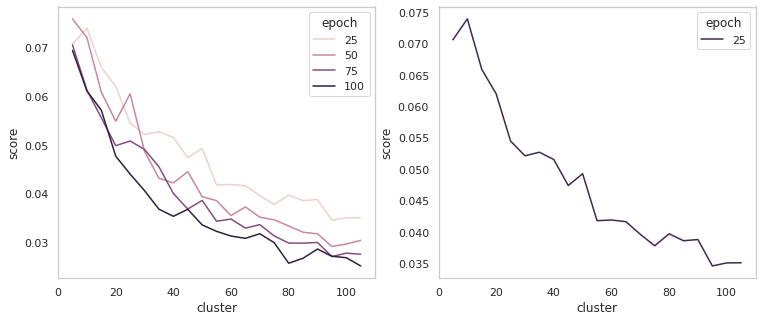

In [15]:
model_topic_scores = {}
for epoch in tqdm(range(25,125,25)):
    epoch_model_score = perform_quick_topic_modelling(epoch,lines=no_cov_lines)
    model_topic_scores[epoch] = epoch_model_score
    
rows = []
for epoch, dic in model_topic_scores.items():
    for cluster, score in dic.items():

            row = {}
            row['epoch'] = epoch
            row['cluster'] = cluster
            row['score'] = score
            rows.append(row)

df2 = pd.DataFrame(rows)

fig, axs = plt.subplots(ncols=2)
sns.color_palette("tab10")
fig.set_figwidth(12.5)
fig.set_figheight(5)
sns.lineplot(x="cluster", y="score", hue="epoch", data=df2, ax=axs[0])
# Put the legend out of the figure
# axs[0].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
sns.lineplot(x="cluster", y="score",  hue="epoch", data=df2.query("epoch==25"), ax=axs[1],palette=sns.cubehelix_palette(light=.2, n_colors=1))
axs[0].grid(False)
axs[1].grid(False)
plt.show()

## Perform Topic Modelling

Identify the best number of epochs, vector size, and k from the results above, and then enter the values below:

In [14]:
topics, tweets,scoreDF,tfidf_matrix,tengrams,tfgrams,centroids,clossest_docs = perform_topic_modelling(25,k=10,lines=no_cov_lines,size=100)
topics

Clustering  Model 25  with k = 10


/home/msparsa2/.local/lib/python3.6/site-packages/ipykernel_launcher.py:44: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).


['0: say, someone, understand, post, medical, op, need, tell, saying, said',
 '1: relationship, life, family, parents, always, mom, health, friends, depression, job',
 '2: meds, medication, doctor, taking, headaches, prescribed, thing, chronic, try, life',
 '3: food, smell, eat, trigger, triggers, give, someone, diet, drink, headaches',
 '4: doctor, headaches, symptoms, brain, cause, thing, neurologist, may, head, sometimes',
 '5: relationship, friends, told, said, friend, together, wanted, talk, boyfriend, asked',
 '6: birth, control, pill, bc, hormonal, doctor, sex, pills, period, risk',
 '7: home, house, mom, told, said, parents, dad, sister, us, job',
 '8: need, someone, relationship, needs, partner, care, husband, say, person, life',
 '9: someone, husband, say, tell, sick, shit, need, said, care, let']

In [15]:
n=[print('Topic descriptors: '+word.split(': ')[1]) for word in topics]

Topic descriptors: say, someone, understand, post, medical, op, need, tell, saying, said
Topic descriptors: relationship, life, family, parents, always, mom, health, friends, depression, job
Topic descriptors: meds, medication, doctor, taking, headaches, prescribed, thing, chronic, try, life
Topic descriptors: food, smell, eat, trigger, triggers, give, someone, diet, drink, headaches
Topic descriptors: doctor, headaches, symptoms, brain, cause, thing, neurologist, may, head, sometimes
Topic descriptors: relationship, friends, told, said, friend, together, wanted, talk, boyfriend, asked
Topic descriptors: birth, control, pill, bc, hormonal, doctor, sex, pills, period, risk
Topic descriptors: home, house, mom, told, said, parents, dad, sister, us, job
Topic descriptors: need, someone, relationship, needs, partner, care, husband, say, person, life
Topic descriptors: someone, husband, say, tell, sick, shit, need, said, care, let


## Interpret the results

In [16]:
sizes = tweets.groupby('topic').count()['tweet'].values
prcg_sizes = [round(word*100/sum(sizes),1) for word in sizes]

In [19]:
copydf = []
for cluster in range(0,len(topics)):
    data = {}
    data['#'] = str(cluster+1)
    data['topic descriptors and n-grams'] = ', '.join(scoreDF[scoreDF['cluster']==cluster].nlargest(10,'weight')['word'].values)
    data['%'] = f'{sizes[cluster]}'
    copydf.append(data)
    data = {}
    data['#'] = ''
    data['%'] = f'{(prcg_sizes[cluster])}%'
    data['topic descriptors and n-grams'] = ', '.join(re.sub(r'\([^)]*\)', '', tengrams[cluster]).split(', ')[:10]).split(': ')[1]
    copydf.append(data)
    print(f'Topic {cluster}: #{sizes[cluster]} ({prcg_sizes[cluster]}%)')
    print('\033[1m'+f'--- Top topic descriptors (highest Relatedness score):'+'\033[0m')
    print(', '.join(scoreDF[scoreDF['cluster']==cluster].nlargest(10,'weight')['word'].values))
    
    print('\033[1m'+f'--- Top temrs with the highest similary score:'+'\033[0m')
    print(', '.join(scoreDF[scoreDF['cluster']==cluster].nlargest(10,'similarity')['word'].values))
    
    print('\033[1m'+f'--- Top temrs with the highest TFIDF score:'+'\033[0m')
    print(', '.join(scoreDF[scoreDF['cluster']==cluster].nlargest(10,'tfidf')['word'].values))
    
    print('\033[1m'+f'--- Top Frequent ngrams:'+'\033[0m')
    print(', '.join(re.sub(r'\([^)]*\)', '', tengrams[cluster]).split(', ')[:20]))
    
    print('\033[1m'+f'--- Top TFIDF ngrams:'+'\033[0m')
    print(', '.join([word for word,i in tfidfNgrams(tweets[tweets['topic']== cluster]['tweet'][:20])]))
    
    print('\033[1m'+f'Top three Exampless:'+'\033[0m')
    print([df.iloc[word].text[:400] for (word,i) in clossest_docs[cluster]][:3])
    print('--------------------------------')
    print()
pd.DataFrame(copydf).to_clipboard()

Topic 0: #471 (7.8%)
--- Top topic descriptors (highest Relatedness score):
say, someone, understand, post, medical, op, need, tell, saying, said
--- Top temrs with the highest similary score:
understand, honest, saying, say, apologize, situation, excuse, obviously, rude, sorry
--- Top temrs with the highest TFIDF score:
say, someone, post, medical, need, op, understand, sick, said, doctor
--- Top Frequent ngrams:
0: mental health, medical issue, medical issues, doctors note, someone else, young man, mental illness, medical condition, auditory hallucinations, health issues, call sick, red flag, makes sense, chronic illness, drug addict, cluster headaches, psychotic disorder, give advice, edit post, trying figure
--- Top TFIDF ngrams:
medical issue, til word, word migraineur, migraineur sorry, sorry suffering, til word migraineur, word migraineur sorry, migraineur sorry suffering, childrens books, took second, second quip, quip thought, thought meant, meant end, end thinking, thinking b

### An example to look at the documents with the most similarity to a topic (These doscuments can also come from other topics):

In [26]:
topic = 9
org = tweets[tweets['topic']== topic].original_index.values
[f'{round(i,2)} '+df.iloc[word].text for (word,i) in clossest_docs[cluster] if word in org][:20] 

["0.86 My wife gets migraines. When she does, I try to help. I do not complain that I can't fuck her.\n\nYour husband is an inconsiderate asshole.",
 "0.8 He sounds like a massive cunt. Just for screaming at you when he knows you've got a migraine.\n\nI have migraines too and this would fuck me right off.\n\nHe's a selfish, inconsiderate bastard.",
 '0.8 Wow. You’re husband is an ass. You had a migraine. This is not ok. \n\nYou have every right to be upset.',
 "0.8 He's obviously never had a migraine. Your son needs to stand up for himself, too. Husband obviously thinks he's a creep. NTA",
 '0.8 My ex (yeah ... EX) used to be like that when I had a migraine. So selfish.',
 "0.79 You should talk to your husband and see if he has a good reason. Make sure you ask him if there's anything he isn't telling you. If he doesn't have anything then it's probably just something he feels. But at the end of the day having a migraine is more than enough of a reason to have an almost adult son take ca

### An example to look at the documents withing a cluster that have the most similarity to that topic:

In [25]:
tweets = t['tweets'].sort_values('closeness',ascending=False)

In [30]:
cluster = 9
for i in range(0,20):
    filt = tweets[(tweets['topic']==cluster) & (tweets['tweet'].apply(lambda x: '' in x))]
    print(filt.iloc[i].closeness,
         df.iloc[filt.index[i]]['text'])
    print('------------------------------')

0.8615480661392212 My wife gets migraines. When she does, I try to help. I do not complain that I can't fuck her.

Your husband is an inconsiderate asshole.
------------------------------
0.8048534989356995 He sounds like a massive cunt. Just for screaming at you when he knows you've got a migraine.

I have migraines too and this would fuck me right off.

He's a selfish, inconsiderate bastard.
------------------------------
0.8023735880851746 Wow. You’re husband is an ass. You had a migraine. This is not ok. 

You have every right to be upset.
------------------------------
0.7999916076660156 He's obviously never had a migraine. Your son needs to stand up for himself, too. Husband obviously thinks he's a creep. NTA
------------------------------
0.7974908947944641 My ex (yeah ... EX) used to be like that when I had a migraine. So selfish.
------------------------------
0.7940849661827087 You should talk to your husband and see if he has a good reason. Make sure you ask him if there's a

### Save the topic modelling results

In [18]:
with open('relationship_100v_10topic_data.pickle', 'wb') as handle:
    pickle.dump({'topics':topics, 'tweets':tweets,'scoreDf':scoreDF, 'tfidf_matrix':tfidf_matrix,
                 'tengrams':tengrams,'tfgrams':tfgrams,'clossest_docs':clossest_docs}, handle)

In [23]:
with open(r'relationship_100v_10topic_data.pickle', 'rb') as handle:
    t = pickle.load(handle)